## Case study 01: Uncertainty estimation and rejection sampling
By Sofia Brisson

In this notebook, we build the initial GemPy model of the Subalpine Molasse triangle zone in Bregenz. Uncertainty is assigned to the model and then rejection sampling is carried out using model topology to get rid of modeling artifacts.

In [1]:
#Importing relevant packages
import warnings
warnings.filterwarnings('ignore')
import gempy as gp
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
from gempy.assets import topology as tp
from tqdm import tqdm_notebook
import seaborn as sns
import pandas as pd
from tqdm import tqdm

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Step 1. Compute the initial model

We initiate the model after assigning it an extent, a resolution, and the path to our surface points. We assign each fault as its own series, and then add all of the lithological layers to a single series for simplicity. This ensures that they will have a concordant relationship and maintain a sub-parallel behavior throughout the model.

In [2]:
geo_model1 = gp.create_model('Bregenz')
geo_mode1l = gp.init_data(geo_model1,
                         extent=[556000,574000,5234000,5275000,-6500,1300], #18 km by 41 km
                         resolution=[80,80,50],
                         path_o='or.csv', #path for orientation data
                         path_i='surf.csv') #path for surface data

#Each surface defined needs to be assigned to a series. 
gp.map_stack_to_surfaces(geo_model1,
                        {'Fault_004' : ['Fault_004'],'Fault_003' : ['Fault_003'],'Fault_001' : ['Fault_001'],
                         'Fault_00' : ['Fault_00'],'Fault_2' : ['Fault_2'],'Fault_3' : ['Fault_3'],'Fault_4' : ['Fault_4'],
                         'Fault_5' : ['Fault_5'],'Fault_6' : ['Fault_6'],'Fault_7' : ['Fault_7'],'Fault_8' : ['Fault_8'],
                         'Fault_9' : ['Fault_9'],'sed_series' : ['UFM','UMM','Up_LFM','LFM','LMM','RDF']})

#We tell GemPy which series are faults
geo_model1.set_is_fault(['Fault_004','Fault_003','Fault_001','Fault_00','Fault_2','Fault_3','Fault_4',
                         'Fault_5','Fault_6','Fault_7','Fault_8','Fault_9'])

#We can customize the layer colors
geo_model1.surfaces.colors.change_colors({'UFM':'#f2f542', 'UMM':'#917e11',
                                         'Up_LFM':'#ccbd6a','LFM':'#ccbd6a',
                                         'LMM' : '#422902', 'RDF' : '#6ba0bf', 'basement' : '#6ba0bf'})

#Interpolate and compute the model - may take some minutes the first time.
interp_data = gp.set_interpolator(geo_model1,
                                 compile_theano=True,
                                 theano_optimizer='fast_run', gradient=False, dype='float32')
gp.compute_model(geo_model1)

#gp.plot_3d(geo_model1, show_lith = False, show_data = True, show_results = True)

Active grids: ['regular']
Fault colors changed. If you do not like this behavior, set change_color to False.
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  12
Compilation Done!
Kriging values: 
                                                      values
range                                          45451.512626
$C_o$                                       49186666.666667
drift equations  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]



Lithology ids 
  [19.         19.         18.02441994 ... 13.         13.
 13.        ] 

In [3]:
#Visualize the raw model using pyvista
gpv = gp.plot_3d(geo_model1, image=False, show_lith=True, show_data=True, show_results=True, plotter_type='background')
gpv.p.set_background(color='gray')
p = gpv.p
#p.remove_bounds_axes()
p.show()

In [7]:
#load the depth points - this is basically the Z value of every single data point that we have, categorized by surface
#we will need this later to assign uncertainty based on depth
depth_points = pd.read_csv('modeling_data/depth_points.csv') 

## Step 2. Uncertainty estimation 

First we save the original coordinates to be able to make the model virgin again after each uncertainty loop.

In [12]:
surf_x_1 = geo_model1.surface_points.df['X']
surf_y_1 = geo_model1.surface_points.df['Y']
surf_z_1 = geo_model1.surface_points.df['Z']

or_x = geo_model1.orientations.df['X']
or_y = geo_model1.orientations.df['Y']
or_z = geo_model1.orientations.df['Z']
or_dip = geo_model1.orientations.df['dip']
or_azimuth = geo_model1.orientations.df['azimuth']

surf_indexes = list(geo_model1.surface_points.df.index)
or_indexes = list(geo_model1.orientations.df.index)

For the uncertainty estimation, here we define that any points with a Z value above 1000 will be considered as surface points and those below 1000 m will be considered subsurface points. The uncertainty will be assigned accordingly.

In [13]:
subsurf_x = geo_model1.surface_points.df['X'][geo_model1.surface_points.df['Z']<=1000]
subsurf_y = geo_model1.surface_points.df['Y'][geo_model1.surface_points.df['Z']<=1000]
subsurf_z = geo_model1.surface_points.df['Z'][geo_model1.surface_points.df['Z']<=1000]

surf_x = geo_model1.surface_points.df['X'][geo_model1.surface_points.df['Z']>1000]
surf_y = geo_model1.surface_points.df['Y'][geo_model1.surface_points.df['Z']>1000]
surf_z = geo_model1.surface_points.df['Z'][geo_model1.surface_points.df['Z']>1000]

mask = np.ones(len(geo_model1.orientations.df), dtype = bool)

#### Uncertainty for surface data

In [14]:
#check the model extent
max_z = surf_z_1.min() # -5000 m
min_z = surf_z_1.max() 

#from there downwards, uncertainty should increase uniformly
min_uncert = 200
max_uncert = 1500 #uncertainty at the maximum depth

In [15]:
# priors: sample from each distribution
def evaluate_sigma(iteration,surface_name, depth_points):
    
    dp_subsurf = depth_points[depth_points <= 1000]
    dp_surf = depth_points[depth_points > 1000]
    
    depth_uncert_subsurf = np.abs((max_uncert*dp_subsurf[surface_name].dropna())/max_z)
    
    #more uncertainty for these faults to the South of the TZ because the seismics from which they are interpreted are very 
    #low resolution.
    if surface_name in ['Fault_00','Fault_001','Fault_003','Fault_004']:
        sigma_1 = np.random.normal(0, 3*(depth_uncert_subsurf))
        sigma_2 = np.random.normal(0, 3*(depth_uncert_subsurf))
        sigma_3 = np.random.normal(0, 4*(depth_uncert_subsurf))
        sigma_4 = np.random.uniform(-200, 200)
        sigma_5 = np.random.uniform(-200, 200)
        sigma_6 = None
        sigma_7 = None
        sigma_8 = None
        sigma_9 = None
        sigma_10 = None
        sigma_11 = None
        
    else:
        sigma_1 = None
        sigma_2 = None
        sigma_3 = None
        sigma_4 = None
        sigma_5 = None
        sigma_6 = np.random.normal(0, np.abs(depth_uncert_subsurf))
        sigma_7 = np.random.normal(0, np.abs(depth_uncert_subsurf))
        sigma_8 = np.random.normal(0, np.abs(1.5*(depth_uncert_subsurf)))
        sigma_9 = np.random.uniform(-150, 150)
        sigma_10 = np.random.uniform(-150, 150)
        sigma_11 = np.random.normal(0, 5)
    
    return [iteration,sigma_1,sigma_2,sigma_3,sigma_4,sigma_5,sigma_6,sigma_7,sigma_8,sigma_9,sigma_10,sigma_11,surface_name]

#### Uncertainty for orientation data
fishdist.py by Elisa Heim - make sure it is present in your working directory.

In [16]:
import copy
import sys
sys.path.append("./")
import fishdist as fish

In [17]:
def create_vMF_list(geo_model, kappas, datatype = 'all'):
    surfaces_df = geo_model.surfaces.df
    orient_df = geo_model.orientations.df
    vMF_list=[]
    
    if datatype == 'faultsonly':
        faults = list(surfaces_df[surfaces_df['isFault'] == True].index)
        df = orient_df[orient_df.surface.isin(faults)]
        
    elif datatype == 'lithonly':
        notfaults = list(surfaces_df[surfaces_df['isFault'] == False].index)
        df = orient_df[orient_df.series.isin(notfaults)]
        
    elif datatype == 'all':
        df = orient_df
        
    else:
        print('nö.')
    for e, i in df[['G_x', 'G_y', 'G_z']].iterrows():
        a = 0
        vMF_list.append(fish.vMF('vMF_' + str(e), mean=i[['G_x', 'G_y', 'G_z']].values, kappa=kappas[a]))
        a += 1
    return vMF_list

In [18]:
# make a copy of the initial dataframe
or_1 = geo_model1.orientations.df.copy()

# define concentration parameter for input data -??? What about the faults
kappadict_1 = {'Fault_004' : 100, 'Fault_003' : 100, 'Fault_001' : 100, 'Fault_00' : 100,
               'Fault_2' : 100, 'Fault_3' : 100, 'Fault_4' : 100, 'Fault_5' : 100, 'Fault_6' : 100,
               'Fault_7' : 100, 'Fault_8' : 100, 'Fault_9' : 100,
               'UFM' : 100, 'UMM' : 100, 'Up_LFM' : 100, 'LFM' : 100, 'LMM' : 100, 'RDF' : 100}

# assign kappa values to the copied dataframe
for surface, kappa in kappadict_1.items():
    or_1.loc[or_1['surface'] == surface, 'kappa'] = kappa #orientations now has a new column with kappa
    
kappas = or_1['kappa']

In [19]:
#in this list, a distribution for every orientation data point is stored, we can sample from that later.
vMF_list = create_vMF_list(geo_model1, kappas, datatype = 'all')

#### Finally, the simulation

In [13]:
surfaces_1 = np.unique(geo_model1.surface_points.df['surface'])

modify_by_surface = True
modify_orientations = True
save = True

n_iterations = 245
run_n = 3

for iteration in tqdm(range(n_iterations)):
    
    #Make model virgin again
    geo_model1.modify_surface_points(surf_indexes, X = surf_x_1, Y = surf_y_1, Z = surf_z_1)
    geo_model1.modify_orientations(or_indexes, X = or_x, Y = or_y, Z = or_z, 
                                       dip = or_dip, azimuth = or_azimuth)
    geo_model1.update_to_interpolator()
        
    if modify_by_surface == True:
        sigma_list = []
        for surf in surfaces_1: 
                
            if surf in ['Fault_00','Fault_001','Fault_003','Fault_004']:
                sigma_list.append(evaluate_sigma(iteration,surf, depth_points))

                subsurf_x[geo_model1.surface_points.df['surface'] == surf] = subsurf_x[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][1]
                subsurf_y[geo_model1.surface_points.df['surface'] == surf] = subsurf_y[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][2]

                # add uncertainty to subsurface position z (uncertainty increases with depth)
                subsurf_z[geo_model1.surface_points.df['surface'] == surf] = subsurf_z[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][3]

                # add uncertainty to surface position x,y
                surf_x[geo_model1.surface_points.df['surface'] == surf] = surf_x[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][4]
                surf_y[geo_model1.surface_points.df['surface'] == surf] = surf_y[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][5]

            else:
                    
                sigma_list.append(evaluate_sigma(iteration,surf, depth_points))

                subsurf_x[geo_model1.surface_points.df['surface'] == surf] = subsurf_x[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][6]
                subsurf_y[geo_model1.surface_points.df['surface'] == surf] = subsurf_y[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][7]

                # add uncertainty to subsurface position z (uncertainty increases with depth)
                subsurf_z[geo_model1.surface_points.df['surface'] == surf] = subsurf_z[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][8]

                # add uncertainty to surface position x,y
                surf_x[geo_model1.surface_points.df['surface'] == surf] = surf_x[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][9]
                surf_y[geo_model1.surface_points.df['surface'] == surf] = surf_y[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][10]

                # add z uncertainty to surface data
                surf_z[geo_model1.surface_points.df['surface'] == surf] = surf_z[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][11]

        if modify_orientations == True:
            new_orientations = np.vstack(list(map(lambda x : x.sample(num_samples = 1, 
                                                                      direct_output = True)[0],vMF_list)))
            a = fish.vMF()
            a.add_orientation_data(new_orientations)

            geo_model1.orientations.df.loc[mask, ['G_x', 'G_y', 'G_z']] = new_orientations
            geo_model1.orientations.df.loc[mask, 'azmiuth'] = a.samples_azdip[:,0]
            geo_model1.orientations.df.loc[mask, 'dip'] = a.samples_azdip[:,1]
        
        geo_model1.update_to_interpolator()
        gp.compute_model(geo_model1)
    
    if save == True:
        np.save('lith_blocks/block_ceres_'+str(run_n)+'_%04d.npy'%iteration, geo_model1.solutions.lith_block)
        np.save('fault_blocks/fblock_ceres_'+str(run_n)+'_%04d.npy'%iteration, geo_model1.solutions.fault_block)
    

100%|██████████████████████████████████████████████████████████████████████████████| 245/245 [5:33:04<00:00, 81.57s/it]


## Step 3. Topology rejection sampling

In [13]:
surfaces_1 = np.unique(geo_model1.surface_points.df['surface'])
G_original, C_original =  tp.compute_topology(geo_model1) #define the original topology information of the model. (G = graphs, C = centroids)

modify_by_surface = True
modify_orientations = True
save = True

n_iterations = 400

#define thresholds
epsilon = 0.195
centroid_cutoff = 240

geo_model1.jaccards_all = []
geo_model1.jaccards_accepted = []
geo_model1.centroid_dist = []
graphs = []
cents = []
n_sim = 0

sigma_values = []
sigma_dataframe = pd.DataFrame()

for iteration in tqdm(range(n_iterations)):
    
    distance = epsilon + 1
    c_diff = centroid_cutoff + 1
   # 
    while distance > epsilon or c_diff > centroid_cutoff:

        #resetting dataframes
        geo_model1.modify_surface_points(surf_indexes, X = surf_x_1, Y = surf_y_1, Z = surf_z_1)
        geo_model1.modify_orientations(or_indexes, X = or_x, Y = or_y, Z = or_z, 
                                   dip = or_dip, azimuth = or_azimuth)
        geo_model1.update_to_interpolator()
    
        if modify_by_surface == True:
            sigma_list = []
            for surf in surfaces_1:
            
                #depth_points =  subsurf_z[geo_model1.surface_points.df['surface'] == surf]
            
                if surf in ['Fault_00','Fault_001','Fault_003','Fault_004']:
                    
                    #sigma evaluation based on depth
                    sigma_list.append(evaluate_sigma(iteration,surf, depth_points))
                    subsurf_x[geo_model1.surface_points.df['surface'] == surf] = subsurf_x[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][1]
                    subsurf_y[geo_model1.surface_points.df['surface'] == surf] = subsurf_y[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][2]
                    
                    # add uncertainty to subsurface position z (uncertainty increases with depth)
                    subsurf_z[geo_model1.surface_points.df['surface'] == surf] = subsurf_z[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][3]
                    
                    # add uncertainty to surface position x,y
                    surf_x[geo_model1.surface_points.df['surface'] == surf] = surf_x[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][4]
                    surf_y[geo_model1.surface_points.df['surface'] == surf] = surf_y[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][5]
                else:
                
                    #sigma evaluation based on depth
                    sigma_list.append(evaluate_sigma(iteration,surf, depth_points))
                    
                    subsurf_x[geo_model1.surface_points.df['surface'] == surf] = subsurf_x[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][6]
                    subsurf_y[geo_model1.surface_points.df['surface'] == surf] = subsurf_y[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][7]
                    
                    # add uncertainty to subsurface position z (uncertainty increases with depth)
                    subsurf_z[geo_model1.surface_points.df['surface'] == surf] = subsurf_z[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][8]
                    
                    # add uncertainty to surface position x,y
                    surf_x[geo_model1.surface_points.df['surface'] == surf] = surf_x[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][9]
                    surf_y[geo_model1.surface_points.df['surface'] == surf] = surf_y[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][10]
                    
                    # add z uncertainty to surface data
                    surf_z[geo_model1.surface_points.df['surface'] == surf] = surf_z[geo_model1.surface_points.df['surface'] == surf]  + sigma_list[-1][11]
        
        if modify_orientations == True:
            new_orientations = np.vstack(list(map(lambda x : x.sample(num_samples = 1, 
                                                                      direct_output = True)[0],vMF_list)))
            a = fish.vMF()
            a.add_orientation_data(new_orientations)
            
            geo_model1.orientations.df.loc[mask, ['G_x', 'G_y', 'G_z']] = new_orientations
            geo_model1.orientations.df.loc[mask, 'azmiuth'] = a.samples_azdip[:,0]
            geo_model1.orientations.df.loc[mask, 'dip'] = a.samples_azdip[:,1]
        
        geo_model1.update_to_interpolator()
        gp.compute_model(geo_model1)
    
        #compute topology graphs and compare them with the original
        G, C = tp.compute_topology(geo_model1)
        j = tp.jaccard_index(G_original, G) #calculate jaccard index based on graph comparison.
    
        geo_model1.jaccards_all.append(j) #save all jaccard indeces
        
        distance = 1 - j
        
        #Now calculate the centroid distance. The distance is caluclated for those centroids that are shared between models.
        c_diff = 0
        for k in (C_original.keys() & C.keys()):
            c_diff += np.sqrt(np.sum(C_original[k] - C[k])**2)
            
        #If the models do not have the same lengh, then a penalty of 50 m is added to the centroid difference.
        if len(C_original) != len(C):
            c_diff = c_diff + 50
    
        n_sim += 1 
    
        if save == True:
            np.save('lith_blocks/block_ceres_240' + str(epsilon) + '_%04d.npy'%iteration, geo_model1.solutions.lith_block)
            np.save('fault_review/fblock_ceres_240'+ str(epsilon) + '_%04d.npy'%iteration, geo_model1.solutions.fault_block)
            
            #save only accepted centroid differences, jaccard indices, graphs and centroids.
            geo_model1.centroid_dist.append(c_diff)
            geo_model1.jaccards_accepted.append(j)
            graphs.append(G)
            cents.append(C)
    

100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [9:40:25<00:00, 87.06s/it]


## Step 4. Check model entropy

#### Posterior lith blocks

In [22]:
#load the lith blocks - may take a while
import os
lith_blocks_list = os.listdir("lith_review")
lith_blocks = np.array([])
for block in lith_blocks_list:
    lith_blocks = np.append(lith_blocks, np.load("lith_review\\" + block))

Now calculate the probability blocks and from that the entropy block.

In [23]:
from gempy.bayesian.fields import compute_prob, calculate_ie_masked
lith_blocks_orient = lith_blocks.reshape(400, -1)
prob_block = compute_prob(lith_blocks_orient)
entropy_block = calculate_ie_masked(prob_block)

In [24]:
#Save the entropy block as a npy file so that next time we don't have to reload all the lith blocks.
np.save("entropy_ps_review.npy", entropy_block)

In [33]:
#calculate the maximum and mean entropy
print(entropy_block.reshape(80,80,50).max())
print(entropy_block.reshape(80,80,50).mean())

2.3078229997465756
0.29483700006164076


#### Posterior Fault blocks

In [25]:
#Do the same but for the fault blocks
fault_blocks_list = os.listdir("fault_review")
fault_block = np.array([])
for fault in fault_blocks_list:
    fault_block = np.append(fault_block, np.load("fault_review\\" + fault)[0, 0:320000]) 

In [26]:
fbo =fault_block.reshape(400,-1)
pb = compute_prob(fbo)
entropy_f = calculate_ie_masked(pb)

In [27]:
np.save("entropy_psf_review.npy", entropy_f)

In [39]:
print(entropy_f.reshape(80,80,50).max())
print(entropy_f.reshape(80,80,50).mean())


2.0714483921968108
0.11775039753161078


#### Check Jaccard indeces

In [71]:
a = np.array([geo_model1.jaccards_accepted])
a = np.around(a, 3)

In [72]:
np.sort(np.unique(a, return_counts = True))

array([[0.805, 0.806, 0.807, 0.808, 0.81 , 0.811, 0.812, 0.813, 0.814,
        0.815, 0.816, 0.817, 0.818, 0.819, 0.82 , 0.821, 0.823, 0.824,
        0.825, 0.826, 0.827, 0.828, 0.829, 0.83 , 0.831, 0.832, 0.833,
        0.834, 0.835, 0.836, 0.837, 0.838, 0.839, 0.84 , 0.841, 0.842,
        0.843, 0.844, 0.845, 0.846, 0.847, 0.848, 0.849, 0.85 , 0.851,
        0.852, 0.853, 0.854, 0.855, 0.856, 0.857, 0.858, 0.859, 0.861,
        0.862, 0.863, 0.864, 0.865, 0.866, 0.867, 0.868, 0.869, 0.871,
        0.872, 0.873, 0.875, 0.876, 0.879, 0.881, 0.883, 0.885, 0.886,
        0.887, 0.89 , 0.891, 0.895, 0.897, 0.904, 0.906, 0.91 , 0.914],
       [1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
        1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
        1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
        2.   , 2.   , 2.   , 2.   , 2.   , 2.   , 2.   , 2.   , 2.   ,
        2.   , 2.   , 2.   , 2.   , 2.   , 2.   , 2.   , 2.   , 2.   ,
     

### Entropy difference figure

In [4]:
# entropy differnce figure.
#load entropy blocks 
entropy_pr = np.load("entropy_block_pr.npy", allow_pickle=True) #prior entropy lith block
entropy_f_pr = np.load("entropy_fblock_pr.npy", allow_pickle=True) #prior entropy fault block
entropy_ps = np.load("entropy_ps_review.npy", allow_pickle=True) #posterior entropy lith block
entropy_f_ps = np.load("entropy_psf_review.npy", allow_pickle=True)#posterior entropy fault block

In [6]:
entropy_diff_lith = entropy_pr - entropy_ps
entropy_diff_fault = entropy_f_pr - entropy_f_ps

In [7]:
print(entropy_diff_lith.max())
print(entropy_diff_fault.max())

0.9208219485842724
0.6929451954706902


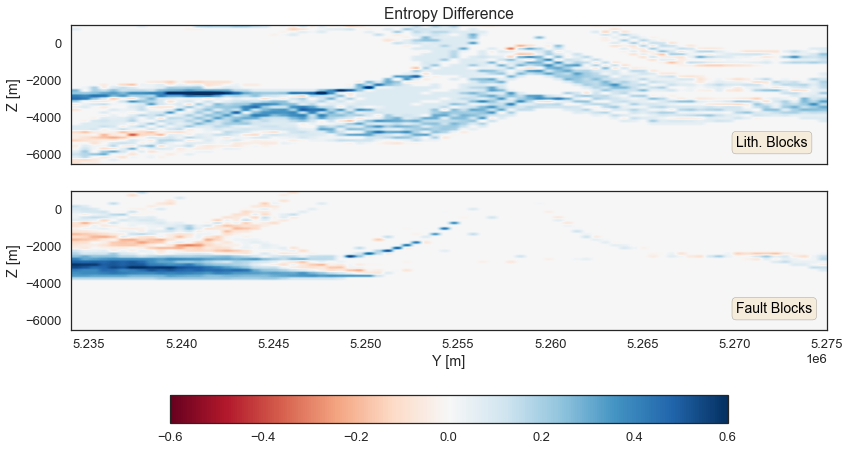

In [8]:
cell = 20
fig, ax= plt.subplots(2,1,sharex = True, figsize = (20,8))

im1 = ax[0].imshow(entropy_diff_lith.reshape(80,80,50)[cell,:,:].T, cmap = 'RdBu', origin = 'lower',
              extent = [5234000,5275000,-6500,1000], clim = [-0.6, 0.6])
im2 = ax[1].imshow(entropy_diff_fault.reshape(80,80,50)[cell,:,:].T, cmap = 'RdBu', origin = 'lower',
              extent = [5234000,5275000,-6500,1000], clim = [-0.6, 0.6])

ax[1].set_xlabel('Y [m]')
ax[0].set_ylabel('Z [m]')
ax[1].set_ylabel('Z [m]')

ax[0].set_title('Entropy Difference')

#cbar_ax = fig.add_axes([0.99, 0.15, 0.03, 0.7])
#fig.colorbar(im1, cax=cbar_ax)

fig.colorbar(im1, ax = ax[:], shrink = 0.5, location = 'bottom')

props = dict(boxstyle = 'round', facecolor = 'wheat', alpha = 0.4)

ax[0].text(0.88,0.1, 'Lith. Blocks',fontsize = 14, verticalalignment = 'bottom', color = 'black',
             transform = ax[0].transAxes, bbox = props)
ax[1].text(0.88,0.1, 'Fault Blocks',fontsize = 14, verticalalignment = 'bottom', color = 'black',
             transform = ax[1].transAxes, bbox = props)

plt.savefig('entropy_difference_REVISED.svg')

In [3]:
#Entropy Figure for overlaying
#define colormap first
# create a colormap
from matplotlib.colors import LinearSegmentedColormap
cdict = {'red':   ((0.0,  1.0, 1.0),
                   (0.5,  0.01, 0.01),
                   (1.0,  0.01, 0.01)),

         'green': ((0.0, 1.0, 1.0),
                   (0.5, 0.36, 0.36),
                   (1.0, 0.99, 0.99)),

         'blue':  ((0.0, 1.0, 1.0),
                   (0.5,  0.98, 0.98),
                   (1.0,  0.96, 0.96)),

         'alpha':  ((0.0,  0.0, 0.0),
                   (0.5,  0.5, 0.5),
                   (1.0,  1.0, 1.0))}

cmap_name = 'entropy_layers'
cm = LinearSegmentedColormap(cmap_name, cdict)
plt.register_cmap(cmap=cm)

cdict2 = {'red':   ((0.0,  1.0, 1.0),
                   (0.5,  0.0, 0.0),
                   (1.0,  0.55, 0.55)),

         'green': ((0.0, 1.0, 1.0),
                   (0.5, 0.52, 0.52),
                   (1.0, 1.0, 1.0)),

         'blue':  ((0.0, 1.0, 1.0),
                   (0.5,  0.31, 0.31),
                   (1.0,  0.0, 0.0)),

         'alpha':  ((0.0,  0.0, 0.0),
                   (0.5,  0.7, 0.7),
                   (1.0,  1.0, 1.0))}

cmap_name2 = 'entropy_faults'
cm2 = LinearSegmentedColormap(cmap_name2, cdict2)
plt.register_cmap(cmap=cm2)

In [ ]:
extent=[556000,574000,5234000,5275000,-6500,1300]

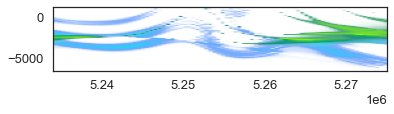

In [14]:
cell = 15

#plt.subplots_adjust(bottom=0.35)
plt.imshow(np.fliplr(entropy_ps.reshape(80,80,50)[cell].T),
           extent = [5234000,5275000,-6500,1300], cmap = "entropy_layers", origin = "lower")
plt.imshow(np.fliplr(entropy_f_ps.reshape(80,80,50)[cell].T),
           extent = [5234000,5275000,-6500,1300], cmap = "entropy_faults", origin = "lower")
plt.savefig("entropy_compare15.svg")